# Vytváření datasetu

(512, 512)
(256, 256)
(512, 512)
(256, 256)
(512, 512)
(256, 256)


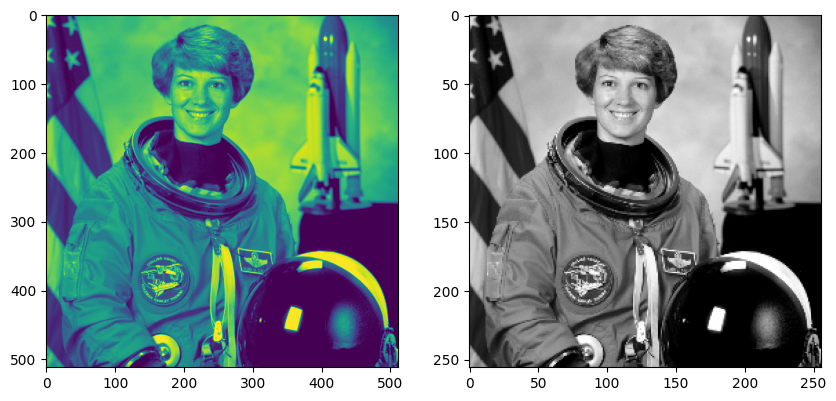

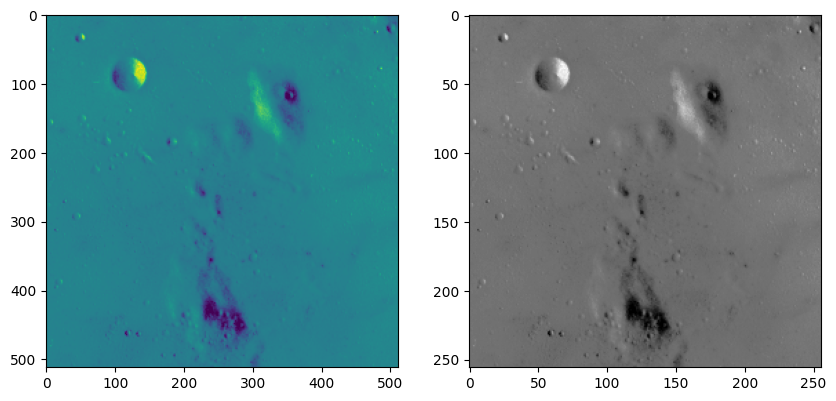

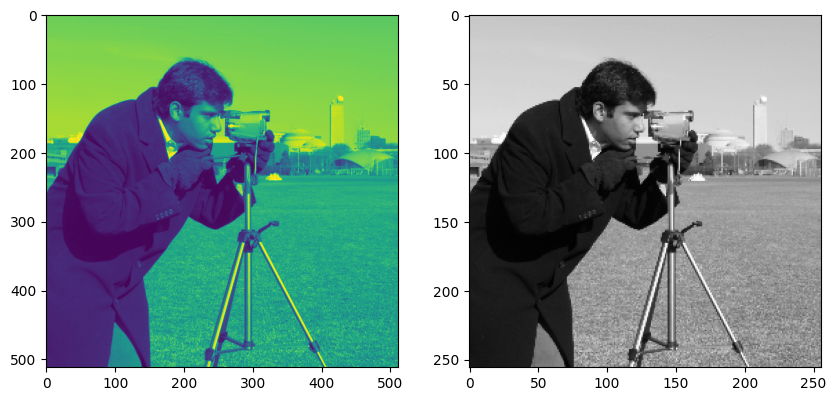

In [41]:
from skimage import data
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.util import img_as_ubyte
import skimage
import numpy as np

images = [rgb2gray(data.astronaut()), data.moon(), data.camera()]
processed_images = []
for image in images:
    processed_image = img_as_ubyte(image)[::2, ::2]
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
    ax0.imshow(image)
    ax1.imshow(processed_image, cmap='gray')
    print(image.shape)
    print(processed_image.shape)
    processed_images.append(processed_image)


## Přidání vertikálního, diagonálního a periodického šumu

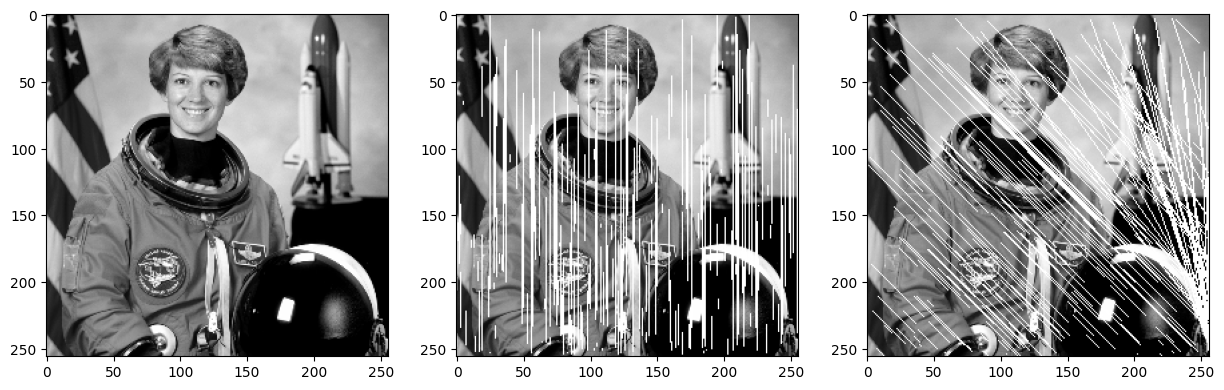

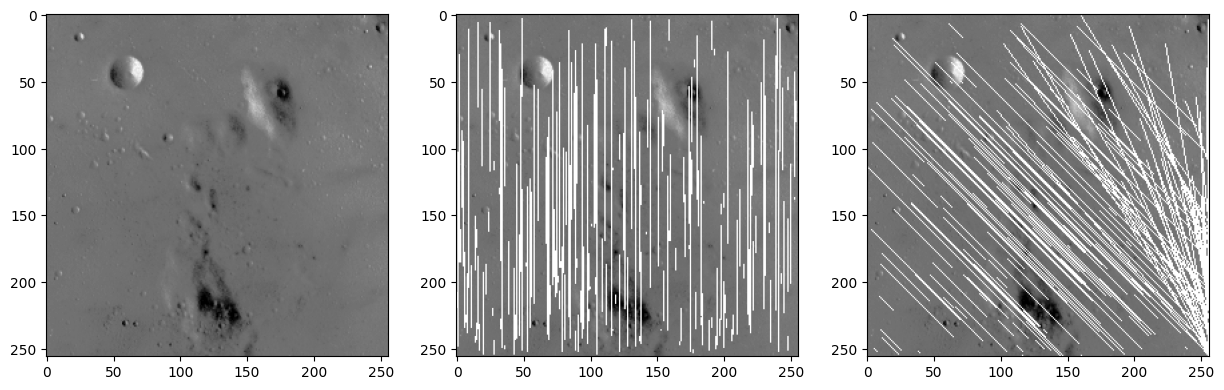

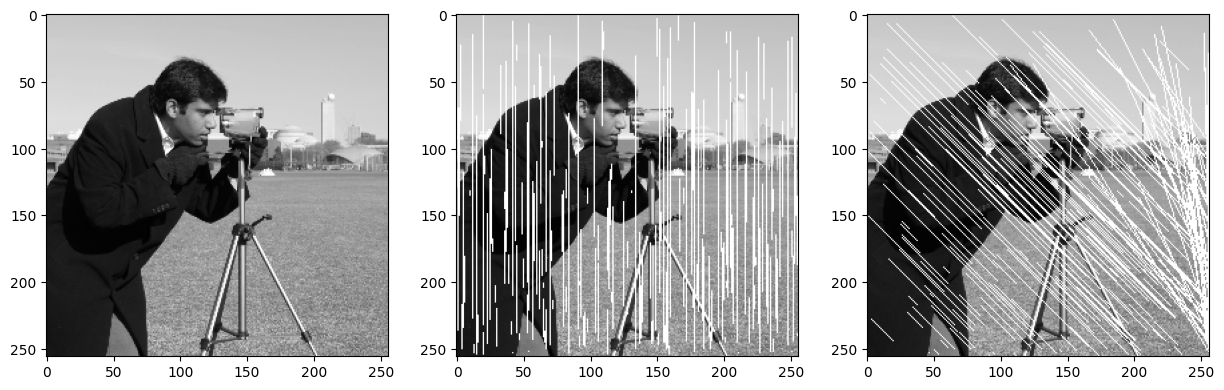

In [ ]:
def add_vertical_lines(img, percentage):
    """Add vertical lines to the image."""
    height, width = img.shape
    affected_pixels = 0
    max_affected_pixels = int(percentage * width * height)
    while affected_pixels < max_affected_pixels:
        column = np.random.randint(0, width)
        # randomly set the row from which to start the vertical line
        start_row = np.random.randint(0, height)
        end_row = np.random.randint(start_row, height)
        img[start_row:end_row, column] = 255  # set the pixel values to 255 (white)
        affected_pixels += end_row - start_row
    return img

def add_diagonal_lines(img, percentage):
    """Add diagonal lines to the image."""
    height, width = img.shape
    affected_pixels = 0
    max_affected_pixels = int(percentage * width * height)
    while affected_pixels < max_affected_pixels:
        start_row = np.random.randint(0, height)
        start_col = np.random.randint(0, width)
        end_row = np.random.randint(start_row, height)
        end_col = start_col + (end_row - start_row) #TODO zaridit aby to bylo jenom diagonalni (end col se bude vypocitavat podle end row nebo tak nejak)
        rr, cc = skimage.draw.line(start_row, start_col, end_row, end_col)
        img[rr, cc] = 255  # set the pixel values to 255 (white)
        affected_pixels += len(rr)
    return img

for processed_image in processed_images:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    ax1.imshow(processed_image, cmap='gray')
    vertical_noise_img = add_vertical_lines(processed_image.copy(), 0.2)
    ax2.imshow(vertical_noise_img, cmap='gray')
    diagonal_noise_img = add_diagonal_lines(processed_image.copy(), 0.2)
    ax3.imshow(diagonal_noise_img, cmap='gray')
    plt.show()
